In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vincenty import vincenty # geopy.distance can also be used

In [2]:
# import pour afficher les cartes
from plotly.offline import iplot, init_notebook_mode
import colorlover as cl
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# init
init_notebook_mode(connected=True)

In [3]:
from sklearn.metrics import SCORERS
from sklearn.model_selection import GridSearchCV

In [4]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [5]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [6]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [7]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [8]:
df_mess_train['lat'] = pos_train['lat']
df_mess_train['lng'] = pos_train['lng']

In [9]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]) for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [10]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [11]:
# on rajoute distance device-station dans df_mess_train
df_mess_train['d_base'] = Eval_geoloc(df_mess_train['bs_lat'],df_mess_train['bs_lng'],pos_train['lat'],pos_train['lng'])

In [12]:
# filtrage final des anomalies du train
df_mess_train_filter = df_mess_train[(df_mess_train['messid']!= '57aeb41fe541cd77a044cdb8')
                      & (df_mess_train['d_base'] <= 50)]
df_mess_train_filter.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,d_base
count,34579.000000,3.457900e+04,34579.000000,34579.000000,3.457900e+04,34579.000000,34579.000000,34579.000000,34579.000000,34579.000000
mean,4335.964979,4.817589e+05,1.044651,-125.899192,1.473000e+12,39.798268,-105.064546,39.786442,-105.059899,5.572419
std,2364.338923,8.630330e+04,0.558705,9.217687,5.577516e+09,0.216214,0.177424,0.216460,0.171193,5.309702
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.026570
25%,2790.000000,4.761850e+05,1.000000,-132.500000,1.467906e+12,39.744848,-105.077530,39.708524,-105.063613,2.013047
50%,3554.000000,4.763150e+05,1.000000,-127.500000,1.472830e+12,39.781464,-105.050984,39.777623,-105.042091,3.983613
75%,4790.000000,4.766020e+05,1.500000,-121.000000,1.478673e+12,39.816224,-105.010048,39.807485,-105.018761,7.496166
max,10148.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,42.850670,-102.011461,43.140387,-102.094289,47.237609


In [13]:
pos_train_filter = pos_train.reindex(df_mess_train_filter.index)

In [14]:
listOfDev = df_mess_train['did'].unique()
len(listOfDev)

113

In [15]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [16]:
len(listOfBs)

259

In [17]:
# Feature Matrix construction avec 0/1 activation balises

def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
#         df_mess_bs_group.get_group(key)
#         df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = 1
        df_feat.loc[idx,elmt['bsid']] = 1
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [18]:
# Feature Matrix construction avec rssi balises -2000 db pour les nan !

def feat_mat_const2(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs)))-2000, columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
#         group = df_mess_bs_group.get_group(key)
#         df_feat.loc[idx,group['bsid']] = group['rssi'].values
        df_feat.loc[idx,elmt['bsid']] = elmt['rssi'].values
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [19]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [20]:
# on regroupe les infos par message feat 0/1
df_feat, id_list_train = feat_mat_const(df_mess_train_filter, listOfBs)
df_feat.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_feat.shape

(5868, 259)

In [22]:
# on regroupe les infos par message feat rssi
df_feat2, id_list_train2 = feat_mat_const2(df_mess_train_filter, listOfBs)
df_feat2.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0
1,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0
2,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0
3,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0
4,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-141.0,-2000.0,-2000.0,-2000.0,...,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0,-2000.0


In [23]:
ground_truth_lat_filter, ground_truth_lng_filter = ground_truth_const(df_mess_train_filter, pos_train_filter)
ground_truth_lat_filter.shape

(5868,)

In [24]:
# liste des devices de chaque message, à utiliser pour la stratégie Leave one/K device Out
dev_id = df_mess_train_filter.groupby(['messid'])['did'].first()
dev_id.shape

(5868,)

In [25]:
# Validation

In [26]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    from sklearn import linear_model

    X_train = np.array(df_feat);
    reg = linear_model.LinearRegression()

    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 
    
    return y_pred_lat, y_pred_lng


In [27]:
# Make regressor and prediction using the train set

In [28]:
# Cross validation

In [29]:
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut, GroupKFold

In [30]:
# apparement demandé par le prof mais très  long
logo = LeaveOneGroupOut()

In [32]:
logo.get_n_splits(df_feat,groups=dev_id)

113

In [33]:
# n_splits=2 pour aller encore plus vite en temps calcul des apprentissages
group_kfold = GroupKFold(n_splits=10)

In [34]:
group_kfold.get_n_splits(df_feat,groups=dev_id)

10

In [35]:
def test_model(reg,df_train,cv):
    # Cross validation
    y_pred_lng = cross_val_predict(reg, df_train, ground_truth_lng_filter,cv=cv.split(df_train,groups=dev_id))
    y_pred_lat = cross_val_predict(reg, df_train, ground_truth_lat_filter,cv=cv.split(df_train,groups=dev_id))

    err_vec = Eval_geoloc(ground_truth_lat_filter , ground_truth_lng_filter, y_pred_lat, y_pred_lng)

    # Plot error distribution

    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values)
    plt.figure()
    plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid()
    plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100])
    plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

    # Error criterion
    print(np.percentile(err_vec, 80))

In [73]:
# n_splits=2 pour aller encore plus vite en gscv
g_k2 = GroupKFold(n_splits=2)

In [37]:
def gscv(model,param_grid,X, y,cv, scoring='r2', semilogx=False):
    '''helper function pour effectuer du grid search sur un hyperparamètre du modèle et afficher la courbe de scores
    et le paramètre optimal'''
    gscv = GridSearchCV(model,param_grid=param_grid,cv=cv,scoring=scoring)
    gscv.fit(X, y, groups=dev_id)
    print("mean CV score",gscv.cv_results_['mean_test_score'])
    print("best param:",gscv.best_params_, gscv.best_score_)
    best_param = list(gscv.best_params_.values())[0]
    if semilogx:
        plt.semilogx(grid,gscv.cv_results_['mean_test_score'])
        plt.semilogx(best_param, gscv.best_score_,'ro')
    else:
        plt.plot(grid,gscv.cv_results_['mean_test_score'])
        plt.plot(best_param, gscv.best_score_,'ro');

In [82]:
def gscv_distance(model,param_grid,X,cv, semilogx=False):
    '''helper function pour effectuer du grid search sur un hyperparamètre du modèle et afficher la courbe de scores
    et le paramètre optimal'''
    model = KNeighborsRegressor(weights='distance')
    scores = []
    cv = group_kfold
    X = df_feat2
    for k, grid in param_grid.items():
        for value in grid:
            model.set_params(**{k:value})
            # Cross validation
            y_pred_lng = cross_val_predict(model, X, ground_truth_lng_filter,cv=cv.split(X,groups=dev_id))
            y_pred_lat = cross_val_predict(model, X, ground_truth_lat_filter,cv=cv.split(X,groups=dev_id))
            err_vec = Eval_geoloc(ground_truth_lat_filter , ground_truth_lng_filter, y_pred_lat, y_pred_lng)
            # Error criterion
            scores.append(np.percentile(err_vec, 80))
        print("CV scores",np.round(scores,2))
        m = np.argmin(scores)
        print("best param:",grid[m],", d_80%:", scores[m])
        if semilogx:
            plt.semilogx(grid,scores)
            plt.semilogx(grid[m], scores[m],'ro')
        else:
            plt.plot(grid,scores)
            plt.plot(grid[m], scores[m],'ro');

### Test pseudo distance

In [38]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()

In [39]:
df_mess_train_filter.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,d_base
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,1.270478
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,7.849924
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554,5.131578
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940,11.681759
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940,1.356862


In [40]:
reg.fit(df_mess_train_filter[['rssi']],df_mess_train_filter['d_base'])

RandomForestRegressor()

In [41]:
reg.predict(df_mess_train_filter[['rssi']])

array([4.82520246, 5.52566942, 7.37150247, ..., 5.51504168, 6.02965468,
       7.65575811])

In [42]:
df_mess_train_filter['pseudo_d'] = reg.predict(df_mess_train_filter[['rssi']])

<ipython-input-42-bc5f51d5edd0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
df_mess_train_filter.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,d_base,pseudo_d
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,1.270478,4.825202
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,7.849924,5.525669
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554,5.131578,7.371502
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940,11.681759,6.924036
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940,1.356862,4.248011


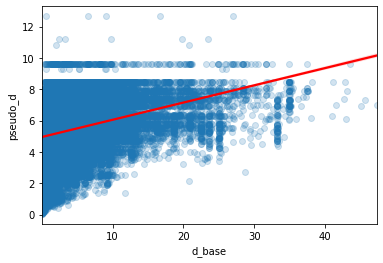

In [44]:
sns.regplot(x=df_mess_train_filter['d_base'],y=df_mess_train_filter[['pseudo_d']],line_kws={'color':'r'},
            scatter_kws={'alpha':0.2});

In [45]:
reg.score(df_mess_train_filter[['rssi']],df_mess_train_filter['d_base'])

0.11038276921097057

In [46]:
# Feature Matrix construction avec pseudo distances

def feat_mat_const3(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))) + 200, columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
#         group = df_mess_bs_group.get_group(key)
#         df_feat.loc[idx,group['bsid']] = group['rssi'].values
        df_feat.loc[idx,elmt['bsid']] = elmt['pseudo_d'].values
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [47]:
# on regroupe les infos par message feat pseudo_distances
df_feat3, id_list_train3 = feat_mat_const3(df_mess_train_filter, listOfBs)
df_feat3.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,200.0,200.0,200.0,200.0,200.0,200.0,200.000000,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
1,200.0,200.0,200.0,200.0,200.0,200.0,200.000000,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
2,200.0,200.0,200.0,200.0,200.0,200.0,200.000000,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
3,200.0,200.0,200.0,200.0,200.0,200.0,200.000000,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
4,200.0,200.0,200.0,200.0,200.0,200.0,7.718189,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0


### LinearRegression

In [326]:
from sklearn import linear_model

In [57]:
# with feat 0/1 & leave one group out

12.470912400000014


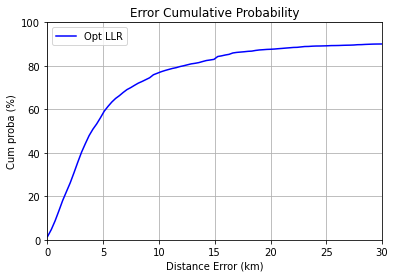

In [327]:
reg = linear_model.LinearRegression()
test_model(reg, df_feat, logo)

In [233]:
# with rssi features LOGO

12.435958400000017


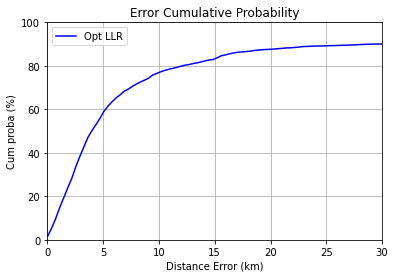

In [328]:
reg = linear_model.LinearRegression()
test_model(reg, df_feat2, logo)

### RandomForestRegressor

In [96]:
from sklearn.ensemble import RandomForestRegressor

In [97]:
# with 0/1 feat LOGO Très Très Long !

In [ ]:
# with 0/1 feat group_kfold 10 OK

6.0803672


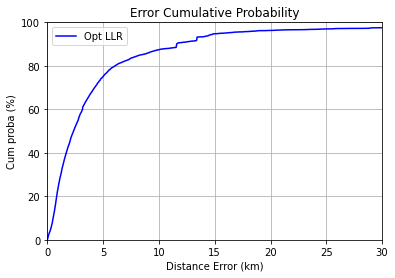

In [329]:
reg = RandomForestRegressor()
test_model(reg, df_feat, group_kfold)

In [271]:
grid = np.logspace(1.7,2.7,10).astype(int)
grid

array([ 50,  64,  83, 107, 139, 180, 232, 300, 388, 501])

In [272]:
param_grid = {'n_estimators': grid}

mean CV score [0.64411076 0.65252035 0.65279546 0.64002115 0.65323402 0.64914488
 0.64952141 0.64640603 0.65254197 0.65269639]
best param: {'n_estimators': 139} 0.653234020132302


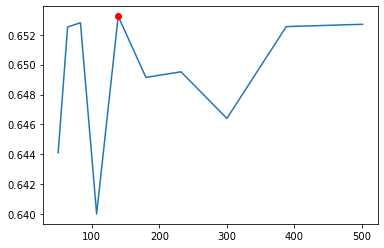

In [273]:
reg = RandomForestRegressor()
gscv(reg,param_grid, df_feat ,ground_truth_lng_filter, g_k2)

In [166]:
# with rssi group_kfold 10 OK

6.658508800000001


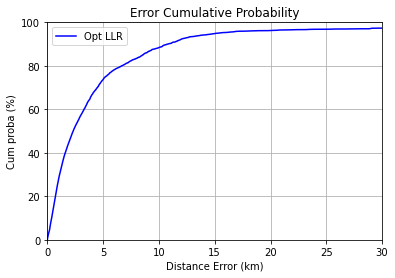

In [330]:
reg = RandomForestRegressor()
test_model(reg, df_feat2, group_kfold)

In [166]:
# with pseudo_distance group_kfold 10 

6.632065800000002


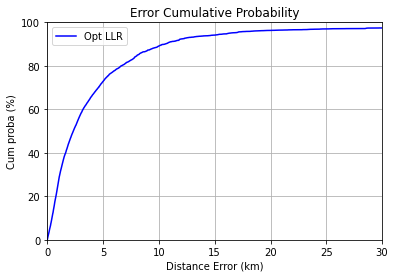

In [289]:
reg = RandomForestRegressor()
test_model(reg, df_feat3, group_kfold)

### Knn

In [49]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# with 0/1 feat group_kfold 10

6.125828200000001


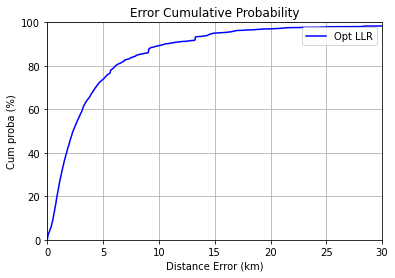

In [331]:
reg = KNeighborsRegressor()
test_model(reg, df_feat, group_kfold)

In [332]:
# with rssi group_kfold 10

5.686495600000001


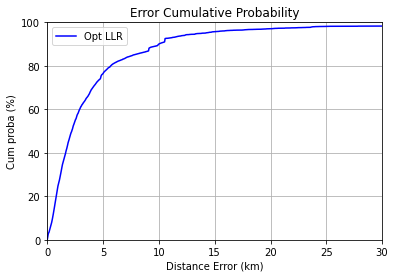

In [333]:
reg = KNeighborsRegressor()
test_model(reg, df_feat2, group_kfold)

#### test de différentes valeurs de k

In [48]:
grid = np.arange(1,30,1)
grid

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [65]:
param_grid = {'n_neighbors': grid}

CV scores [7.83 6.76 6.22 6.09 5.93 5.89 5.91 5.37 6.1  6.21 6.32 5.93 6.   6.01
 6.04 6.04 6.09 6.17 6.19 6.58 6.69 6.83 6.99 7.08 7.12 7.19 7.21 7.28
 7.3 ]
best param: 8 , d_80%: 5.371804


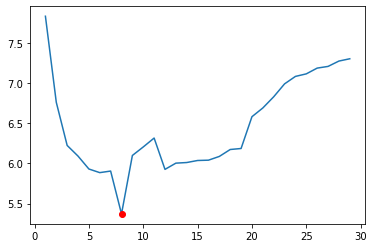

In [83]:
model = KNeighborsRegressor(weights='distance')
gscv_distance(model,param_grid,df_feat2,group_kfold)

best k

5.371804


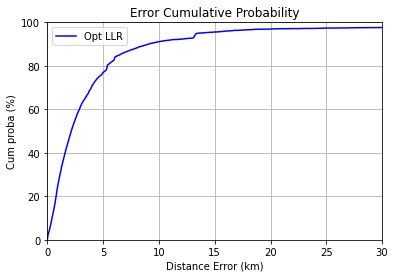

In [394]:
reg = KNeighborsRegressor(8,weights='distance')
test_model(reg, df_feat2, group_kfold)

In [334]:
# with pseudo distance group_kfold

5.860102


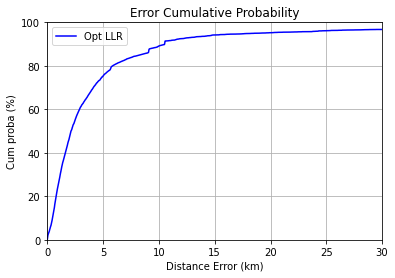

In [335]:
reg = KNeighborsRegressor()
test_model(reg, df_feat3, group_kfold)

### GradientBoostingRegressor

In [336]:
from sklearn.ensemble import GradientBoostingRegressor

8.2787638


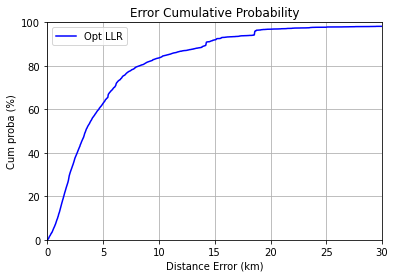

In [337]:
# with 0/1 feat group_kfold 10 OK
reg = GradientBoostingRegressor(n_estimators=500)
test_model(reg, df_feat, group_kfold)

In [ ]:
# with rssi group_kfold 10 

8.621531000000001


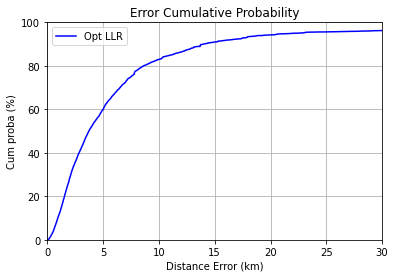

In [338]:
reg = GradientBoostingRegressor(n_estimators=500)
test_model(reg, df_feat2, group_kfold)

### XGBoost Regressor

In [174]:
import xgboost as xgb
from xgboost import XGBRegressor

7.053392200000001


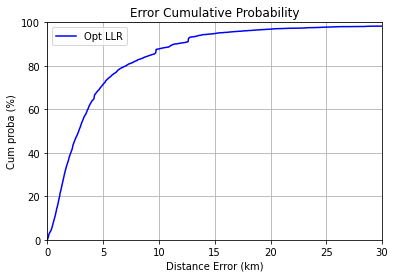

In [339]:
# with 0/1 feat group_kfold 10 OK
reg = XGBRegressor(n_estimators=500)
test_model(reg, df_feat, group_kfold)

8.204867000000005


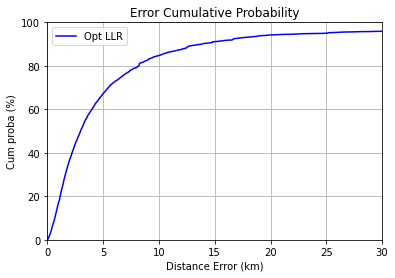

In [340]:
# with rssi group_kfold 10 OK
reg = XGBRegressor(n_estimators=500)
test_model(reg, df_feat2, group_kfold)

In [25]:
# Construct test prediction

In [44]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [78]:
df_feat, id_list_train = feat_mat_const(df_mess_train, listOfBs)

In [83]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

In [84]:
df_feat_test, id_list_test = feat_mat_const(df_mess_test, listOfBs)

In [85]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

In [86]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

In [87]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [88]:
test_res.head()

,lat,lng,messid
0,39.772912,-105.049629,573be2503e952e191262c351
1,39.774800,-105.062448,573c05f83e952e1912758013
2,39.678750,-105.012794,573c0796f0fe6e735a66deb3
3,39.773684,-105.037449,573c08d2864fce1a9a0563bc
4,39.678750,-105.012794,573c08ff864fce1a9a0579b0
